In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Sequential
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2024-02-13 19:26:24.153651: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-13 19:26:24.153783: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-13 19:26:24.295992: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/digit-recognizer/train.csv")
print(train_data.shape)
train_data.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
test_data = pd.read_csv("/kaggle/input/digit-recognizer/test.csv")
print(test_data.shape)
test_data.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Convert pixel values to floats.

In [4]:
X_train = pd.get_dummies(train_data.iloc[:,1:])
X_train = X_train.values.astype('float32')

y_train = pd.get_dummies(train_data.iloc[:,0])
y_train = y_train.values.astype('int16')

X_test = test_data.values.astype('float32')

# Reshaping the Data
Since each image is 28x28 pixels and one color channel, reshape to these dimensions.  We use a -1 to signify we want the dimension to be calculated for us.

In [5]:
X_train = X_train.reshape(-1, 28, 28,1)
X_test = X_test.reshape(-1,28,28,1)

Let's have a look at this data to see what we are working with.

In [6]:
print('X_train shape: ', X_train.shape)

X_train shape:  (42000, 28, 28, 1)


The training data has 42,000 images that are made up of 28x28pixels(784 in total) with 1 color channel

Let's see what some of the images look like.

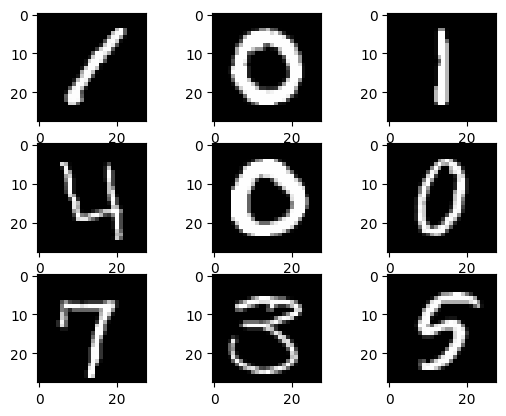

In [7]:
for i in range(0, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))

# Data Preprocessing

In this case we will simply scale all our greyscale pixel values (0-255) to be between 0 and 1. We can do this by dividing each value in the training and testing sets by 255.0. We do this because smaller values will make it easier for the model to process our values.

In [8]:
X_train = X_train / 255.0
X_test = X_test / 255.0

# Split the data

In [9]:
X=X_train
y=y_train
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.10, random_state=0)

# CNN Architecture

(This explanation is taken diretly from Machine Learning with Python course at https://www.freecodecamp.org/learn/machine-learning-with-python/tensorflow/)

A common architecture for a CNN is a stack of Conv2D and MaxPooling2D layers followed by a few denesly connected layers. To idea is that the stack of convolutional and maxPooling layers extract the features from the image. Then these features are flattened and fed to densly connected layers that determine the class of an image based on the presence of features.

We will start by building the **Convolutional Base**.

In [10]:
model = keras.models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


# # we'll use categorical xent for the loss, and RMSprop as the optimizer
# model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

**Layer 1**

The input shape of our data will be 28, 28 and we will process 32 filters of size 3x3 over our input data. We will also apply the activation function relu to the output of each convolution operation.

**Layer 2**

This layer will perform the max pooling operation using 2x2 samples and a stride of 2.

**Other Layers**

The next set of layers do very similar things but take as input the feature map from the previous layer. They also increase the frequency of filters from 32 to 64. We can do this as our data shrinks in spacial dimensions as it passed through the layers, meaning we can afford (computationally) to add more depth.

In [11]:
model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55744 (217.75 KB)
Trainable params: 55744 

# Adding Dense Layers
So far, we have just completed the **convolutional base**. Now we need to take these extracted features and add a way to classify them. This is why we add the following layers to our model.


In [12]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

We can see that the flatten layer changes the shape of our data so that we can feed it to the 64-node dense layer, follwed by the final output layer of 10 neurons (one for each class).


# Compiling the Model.  

Here are some reasons why you might choose the given model configuration:

**Adam Optimizer:**

* Adam is an adaptive learning rate optimization algorithm that combines the advantages of both AdaGrad and RMSProp.
* It is well-suited for a wide range of deep learning tasks and often converges faster than other optimization algorithms.
* Adam adjusts the learning rates of each parameter dynamically during training, which can lead to more efficient convergence and better generalization.

**Categorical Crossentropy Loss with logits:**

* Categorical Crossentropy loss is suitable for multi-class classification tasks where each instance can belong to one class out of several mutually exclusive classes.
* Using logits allows the model to output raw predictions before applying the softmax activation function. This can be useful if you want to apply additional customizations or if the model's output is already in the logit form.
* Categorical Crossentropy loss is commonly used in conjunction with softmax activation for the output layer to measure the discrepancy between the predicted probability distribution and the true distribution of classes.

**Accuracy Metric:**

* Accuracy is a commonly used metric for classification tasks, providing the ratio of correctly predicted instances to the total number of instances.
* It offers a straightforward interpretation of the model's performance in terms of correct classifications and is easy to understand and communicate.

**Flexibility and Customization:**

* By setting from_logits=True, you have the flexibility to work with raw logits instead of probabilities, allowing for more advanced customization or manipulation of model outputs.
* This flexibility can be particularly useful in scenarios where post-processing steps are required or when integrating the model into more complex architectures.

**Robustness and Stability:**

* The Adam optimizer is known for its robustness and stability, making it less sensitive to the choice of hyperparameters compared to some other optimization algorithms.
* It tends to perform well across a wide range of tasks and datasets, making it a popular choice for many deep learning practitioners.

Overall, this model configuration offers a combination of optimization algorithm, loss function, and evaluation metric suitable for multi-class classification tasks, with considerations for efficiency, flexibility, and robustness in training deep neural networks.

"List reasons to use this model: model.compile(optimizer='adam', loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True), metrics=['accuracy'])" prompt. ChatGPT, 3.5, OpenAI, 13 Feb. 2024. https://chat.openai.com.

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

In [15]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val,y_val),
    epochs=6)

Epoch 1/6


I0000 00:00:1707852407.617070      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1182/1182 [==============================] - 9s 4ms/step - loss: 0.1813 - accuracy: 0.9440 - val_loss: 0.0683 - val_accuracy: 0.9790
Epoch 2/6
1182/1182 [==============================] - 5s 4ms/step - loss: 0.0565 - accuracy: 0.9826 - val_loss: 0.0594 - val_accuracy: 0.9805
Epoch 3/6
1182/1182 [==============================] - 4s 4ms/step - loss: 0.0385 - accuracy: 0.9879 - val_loss: 0.0390 - val_accuracy: 0.9871
Epoch 4/6
1182/1182 [==============================] - 4s 4ms/step - loss: 0.0303 - accuracy: 0.9901 - val_loss: 0.0384 - val_accuracy: 0.9881
Epoch 5/6
1182/1182 [==============================] - 4s 4ms/step - loss: 0.0244 - accuracy: 0.9915 - val_loss: 0.0384 - val_accuracy: 0.9881
Epoch 6/6
1182/1182 [==============================] - 4s 4ms/step - loss: 0.0181 - accuracy: 0.9940 - val_loss: 0.0362 - val_accuracy: 0.9886


                  Minimum validation loss: 0.03620140254497528
                   Ending validation loss: 0.03620140254497528


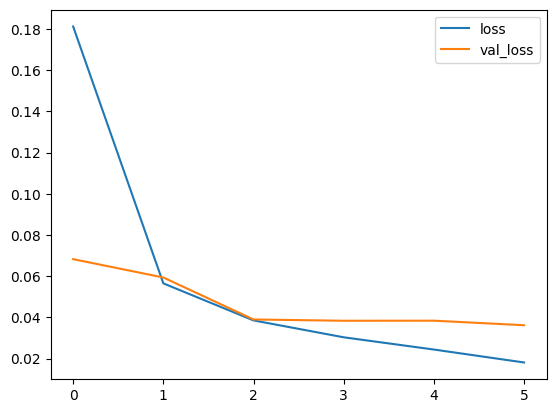

In [16]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot();
min_val_loss = history_df['val_loss'].min()
ending_val_loss = history_df['val_loss'].iloc[-1]  # Fetching the last val_loss value
print("                  Minimum validation loss: {}".format(min_val_loss))
print("                   Ending validation loss: {}".format(ending_val_loss))

# Making Predictions
To make predictions we simply need to pass an array of data in the form we've specified in the input layer to ```.predict()``` method.

In [17]:
predictions = model.predict(X_val)

132/132 [==============================] - 0s 2ms/step


# Verifying predcitions

The following script had to be commented out since no user input is permitted for Kaggle's submissions.
Uncomment to input a item number and see an image of the data for that item , the model's prediction, and the actual value.

In [18]:
# def show_image(img):
#   plt.figure()
#   plt.imshow(img, cmap=plt.cm.binary)
#   plt.grid(False)
#   plt.show()
  
# def get_number():
#   while True:
#     num = input("Pick a number: ")
#     if num.isdigit():
#       num = int(num)
#       if 0 <= num < 4200:
#         return int(num)
#       else:
#         print("Try again...")
#     else:
#         print("Try again...")

# num = get_number()
# show_image(X_val[num])
# print('Predicated value: ', np.argmax(predictions[num]))
# print('Actual number: ', list(y_val[num]).index(1))

# A sample output of the previous script:

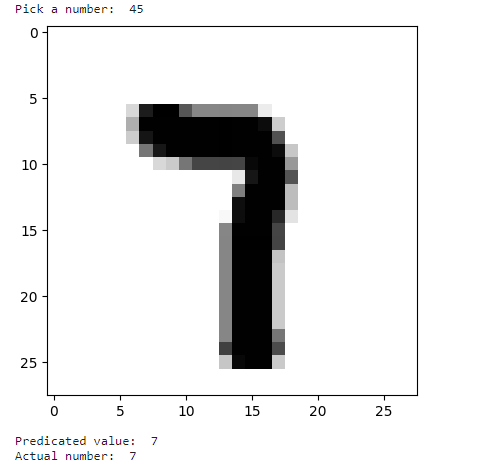

In [19]:
predictions = model.predict(X_test)
X_test.shape

875/875 [==============================] - 1s 2ms/step


(28000, 28, 28, 1)

In [20]:
predictions = np.argmax(predictions, axis = 1)
predictions = pd.Series(predictions,name = "Label")

In [21]:
submission = pd.concat([pd.Series(range(1,28001), name = "ImageId"),predictions],axis = 1)
submission.to_csv("DR.csv", index = False)